In [1]:
import sys
sys.path.insert(0, "KPConv-PyTorch/")
import pandas as pd
import numpy as np
from skimage.io import imread, imshow
import sys
from scipy.ndimage import zoom
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from glob import glob

from models.architectures import KPFCNN
from utils.config import Config
import cpp_wrappers.cpp_neighbors.radius_neighbors as cpp_neighbors
#np.set_printoptions(threshold=sys.maxsize)

NUM_EPOCHS = 10
BATCH_SIZE = 3
NUM_CHANNEL = 1
IMAGE_DEPTH, IMAGE_WIDTH, IMAGE_HEIGHT = 32, 128, 128
device = torch.device("cuda:0")

# Doubts

1. What is kernal size of kernal point in KPCOnv class?

# Note

1. Dont send all points in dataloader because the GPU usage shoots to 5k GB.
2. Try to adapt datasets/S3DIS.py to suit your datset.

In [2]:
def resize_3d_volume(input_volume, output_shape):
    input_shape = input_volume.shape
    zoom_factor = output_shape / input_shape
    #print("Resizing {} to {} by the factor {}".format(input_shape, output_shape, zoom_factor))
    return zoom(input_volume, zoom=zoom_factor)

def convert_to_pointcloud(input_array, is_mask = False):
    i = 0
    if is_mask:
        point_cloud = np.ones(shape = (input_array.size, 1))
    else:
        point_cloud = np.ones(shape = (input_array.size, 4))
    for slice_num in range(input_array.shape[0]):
        for col_num in range(input_array.shape[1]):
            for row_num in range(input_array.shape[2]):
                if is_mask:
                    point_cloud[i, ] = [input_array[slice_num, row_num, col_num]]
                else:
                    point_cloud[i, ] = [row_num, col_num, slice_num, input_array[slice_num, row_num, col_num]] 
                i = i+1
    return point_cloud

def convert_from_pointcloud(input_pt_cloud):
    np_array = input_pt_cloud.size
    pass

In [3]:
class CellNetConfig(Config):
    # dataset
    dataset = 'Fluo-C3DH-A549'
    num_classes = 2
    first_subsampling_dl = 0.02
    in_features_dim = 4
    data_train_dir = "./data/Fluo-C3DH-A549/01/"
    data_test_dir = "./data/Fluo-C3DH-A549/01_GT/"
    train_batch_size = 8
    test_batch_size = 8
    conv_radius = 2.5
    # model
    architecture = ['simple',
                    'resnetb',
                    ]
    dropout = 0.5
    resume = None
    use_batch_norm = True
    batch_norm_momentum = 0.02
    # https://github.com/pytorch/examples/issues/289 pytorch bn momentum 0.02 == tensorflow bn momentum 0.98

    # kernel point convolution
    KP_influence = 'linear'
    KP_extent = 1.0
    convolution_mode = 'sum'

    # training
    max_epoch = 200
    learning_rate = 5e-3
    momentum = 0.98
    exp_gamma = 0.1 ** (1 / 80)
    exp_interval = 1

In [4]:
cfg = CellNetConfig()
model = KPFCNN(cfg, [0, 1], [])

In [5]:
device = torch.device("cuda")
model = model.to(device)

In [6]:
class data_row():
    def __init__(self, points, features, labels, n_list):
        self.points = points.to(device)
        self.features = features.to(device)
        self.labels = labels.to(device)
        self.neighbors = n_list

In [7]:
from datasets.common import PointCloudDataset
class pointcloudDataset(PointCloudDataset):
    """Cell Segmentation dataset."""

    def __init__(self, root_dir, config):
        self.root_dir = root_dir
        self.config = config
        self.batch_size = BATCH_SIZE
    
    def __len__(self):
        return len(list(glob(self.root_dir + '_GT/SEG/*.tif')))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        mask_names = glob(self.root_dir + '_GT/SEG/*.tif')
        train_image_name = self.root_dir + '/t{}'.format(mask_names[idx][-7:-4] + '.tif')
        
        train_image = imread(train_image_name)
        v_min = train_image.min(axis=(1, 2), keepdims=True)
        v_max = train_image.max(axis=(1, 2), keepdims=True)
        train_image = ((train_image - v_min)/(v_max - v_min) * 255).astype('uint8')
        train_image = resize_3d_volume(train_image, np.array([IMAGE_DEPTH, IMAGE_WIDTH, IMAGE_HEIGHT]))
        train_point_cloud = convert_to_pointcloud(train_image)
        
        print(train_point_cloud)

        mask_image = (imread(mask_names[idx]))
        mask_image = resize_3d_volume(mask_image, np.array([IMAGE_DEPTH, IMAGE_WIDTH, IMAGE_HEIGHT]))

        mask_point_cloud = convert_to_pointcloud(mask_image, is_mask = True)
        
        points = torch.Tensor(train_point_cloud[:, :3])
        features = torch.Tensor(train_point_cloud[:, -1]).reshape(1, -1)
        
        #features = torch.cat((features, features), 0)
        
        labels = torch.Tensor(mask_point_cloud)
        l = np.array([points.shape[0]], dtype=np.int32)
        r_normal = self.config.first_subsampling_dl * self.config.conv_radius
#         train_data = np.hstack((train_point_cloud, mask_point_cloud))
        
        #input_list = segmentation_inputs(train_point_cloud[:, :3], train_point_cloud[:, -1], mask_point_cloud, self.config)
        n_list = cpp_neighbors.batch_query(points, points, l, l, radius = 1.5)
        
        row = data_row(points, features, labels, n_list)
        return row

In [8]:
data_loader = pointcloudDataset("./data/Fluo-C3DH-A549/01", cfg)

In [9]:
#model.to(device = device)
for data in data_loader:
#     print(data.features)
#     model(data, cfg)
    break

[[  0.   0.   0.  20.]
 [  1.   0.   0.  57.]
 [  2.   0.   0.  87.]
 ...
 [125. 127.  31.  52.]
 [126. 127.  31.  11.]
 [127. 127.  31.   6.]]


In [3]:
import matplotlib.pyplot as plt
import colormaps as cmaps

ModuleNotFoundError: No module named 'colormaps'

In [2]:
from matplotlib.colors import ListedColormap
viridis = ListedColormap(_viridis_data, name='viridis')
plt.register_cmap(name='viridis', cmap=viridis)
plt.set_cmap(viridis)

NameError: name '_viridis_data' is not defined

In [4]:
x = [5, 6, 7, 8, 9]

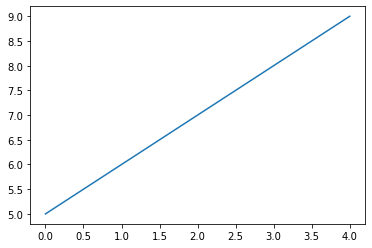

In [5]:
plt.plot(x)